In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
# must be >=2.6.2
tf.__version__
# !pip install --upgrade tensorflow

'2.6.2'

# Pipeline that outputs the triplets

In [4]:
target_shape = (200,200)

def get_object(row, image):
    id_, x, y, w, h = row
    id_ = int(id_)
    x = int(max(x,0))
    y = int(max(y,0))
    w = int(min(w,image.shape[1]-x))
    h = int(min(h,image.shape[0]-y))
    if y == -1: y = 0
    if x == -1: x = 0
    obj = image[y:y+h,x:x+w]
    obj = cv2.resize(obj, dsize=target_shape, interpolation=cv2.INTER_CUBIC)
    obj = obj.astype(np.float32)
    obj /= 255.
    return obj

def triplet_gen():
    # gt file header
    header = {"frame":0, "id":1, "x":2, "y":3, "w":4, "h":5, "x1":6, "x2":7, "conf":9}

    # get the list of gt files
    train_gt_files = sorted(glob.glob("data/train/*/*/gt.txt"))
    val_gt_files = train_gt_files[-1:]
    train_gt_files = train_gt_files[:-1]

    for gt_file in train_gt_files:
        gt = np.loadtxt(gt_file,delimiter=",")
        frames = np.unique(gt[:,header["frame"]])
        for frame in frames:
            image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(frame)))
            image = cv2.imread(image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gt_frame = gt[gt[:,header["frame"]] == frame]
#             plt.figure(figsize=(20,20))
#             plt.imshow(image)
#             plt.show()
            for row in gt_frame:
                positive_data = gt[gt[:,header["id"]] == row[header["id"]]]
                positive_index = np.random.choice(len(positive_data), size=1)[0]
                positive_row = positive_data[positive_index]
                positive_frame = positive_row[header["frame"]]
                positive_image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(positive_frame)))
                positive_image = cv2.imread(positive_image_file)
                positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
                negative_data = gt_frame[gt_frame[:,header["id"]] != row[header["id"]]]
                negative_index = np.random.choice(len(negative_data), size=1)[0]
                negative_row = negative_data[negative_index]
                anchor = get_object(row[1:6], image)
                positive = get_object(positive_row[1:6], positive_image)
                negative = get_object(negative_row[1:6], image)
                yield anchor,positive,negative

dataset = tf.data.Dataset.from_generator(triplet_gen, (tf.float32,tf.float32,tf.float32), (target_shape + (3,),target_shape + (3,),target_shape + (3,)))

In [5]:
dataset

<FlatMapDataset shapes: ((200, 200, 3), (200, 200, 3), (200, 200, 3)), types: (tf.float32, tf.float32, tf.float32)>

0


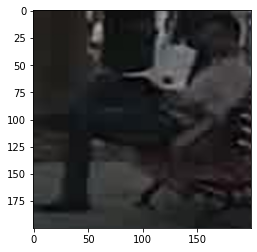

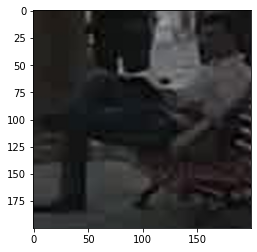

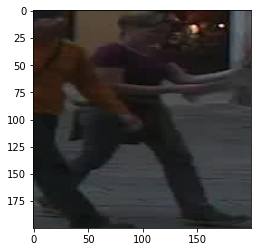

1


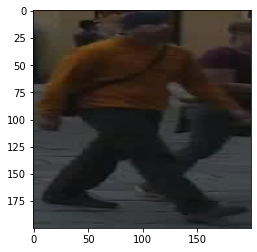

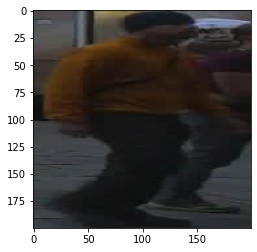

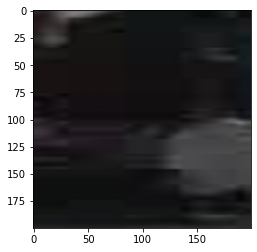

2


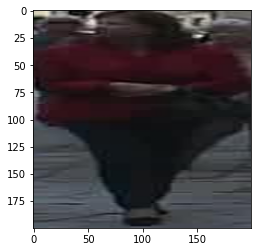

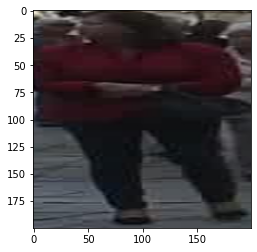

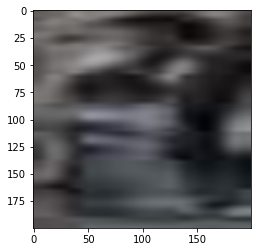

3


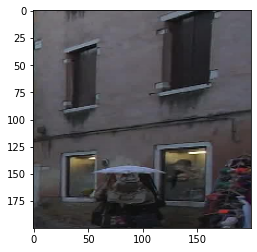

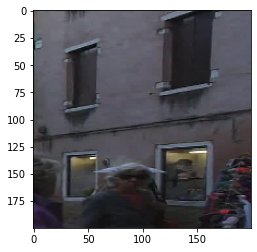

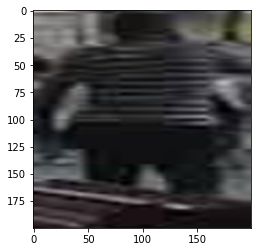

4


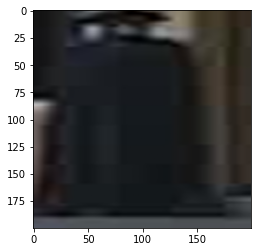

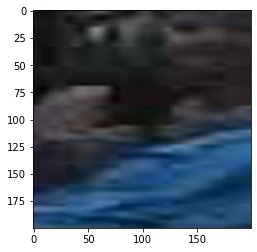

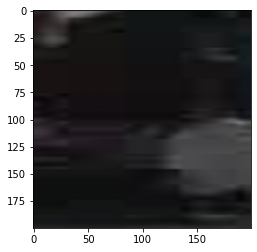

In [6]:
for j,i in enumerate(dataset):
    print(j)
    plt.imshow(i[0])
    plt.show()
    plt.imshow(i[1])
    plt.show()
    plt.imshow(i[2])
    plt.show()

    if j > 3:
        break

# Pipeline that outputs the triplet and their location

In [7]:
target_shape = (200,200)

def get_object(row, image):
    id_, x, y, w, h = row
    id_ = int(id_)
    x = int(max(x,0))
    y = int(max(y,0))
    w = int(min(w,image.shape[1]-x))
    h = int(min(h,image.shape[0]-y))
    if y == -1: y = 0
    if x == -1: x = 0
    obj = image[y:y+h,x:x+w]
    obj = cv2.resize(obj, dsize=target_shape, interpolation=cv2.INTER_CUBIC)
    obj = obj.astype(np.float32)
    obj /= 255.
    return obj

def triplet_gen():
    # gt file header
    header = {"frame":0, "id":1, "x":2, "y":3, "w":4, "h":5, "x1":6, "x2":7, "conf":9}

    # get the list of gt files
    train_gt_files = sorted(glob.glob("data/train/*/*/gt.txt"))
    val_gt_files = train_gt_files[-1:]
    train_gt_files = train_gt_files[:-1]

    for gt_file in train_gt_files:
        gt = np.loadtxt(gt_file,delimiter=",")
        frames = np.unique(gt[:,header["frame"]])
        for frame in frames:
            image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(frame)))
            image = cv2.imread(image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gt_frame = gt[gt[:,header["frame"]] == frame]
#             plt.figure(figsize=(20,20))
#             plt.imshow(image)
#             plt.show()
            for row in gt_frame:
                positive_data = gt[gt[:,header["id"]] == row[header["id"]]]
                positive_index = np.random.choice(len(positive_data), size=1)[0]
                positive_row = positive_data[positive_index]
                positive_frame = positive_row[header["frame"]]
                positive_image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(positive_frame)))
                positive_image = cv2.imread(positive_image_file)
                positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
                negative_data = gt_frame[gt_frame[:,header["id"]] != row[header["id"]]]
                negative_index = np.random.choice(len(negative_data), size=1)[0]
                negative_row = negative_data[negative_index]
                anchor = get_object_location(row[1:6], image)
                positive = get_object_location(positive_row[1:6], positive_image)
                negative = get_object_location(negative_row[1:6], image)
                yield anchor,positive,negative

dataset = tf.data.Dataset.from_generator(triplet_gen, ((tf.float32,tf.int32),(tf.float32,tf.int32),(tf.float32,tf.int32)), ((target_shape + (3,),(4,)),(target_shape + (3,),(4,)),(target_shape + (3,),(4,))))

In [8]:
dataset

<FlatMapDataset shapes: (((200, 200, 3), (4,)), ((200, 200, 3), (4,)), ((200, 200, 3), (4,))), types: ((tf.float32, tf.int32), (tf.float32, tf.int32), (tf.float32, tf.int32))>